# Analysis of Airbnb Listings in Seattle in 2009-2016

In this notebook, we analyze data for Airbnb listings in Seattle from this Kaggle link (https://www.kaggle.com/airbnb/seattle/data) to look for patterns that point to what kind of listing features such as neighborhood, property type, amenities, etc. would appeal strongly to customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
listings = pd.read_csv('listings.csv')

In [3]:
listings.select_dtypes('int')

,id,scrape_id,host_id,accommodates,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,calculated_host_listings_count
0,241032,20160104002432,956883,4,2,1,365,14,41,71,346,207,2
1,953595,20160104002432,5177328,4,1,2,90,13,13,16,291,43,6
2,3308979,20160104002432,16708587,11,10,4,30,1,6,17,220,20,2
3,7421966,20160104002432,9851441,3,1,1,1125,0,0,0,143,0,1
4,278830,20160104002432,1452570,6,6,1,1125,30,60,90,365,38,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,20160104002432,31148752,6,1,3,1125,18,32,32,32,1,8
3814,8902327,20160104002432,46566046,4,3,2,29,6,26,44,273,2,1
3815,10267360,20160104002432,52791370,2,2,1,7,29,59,88,88,0,1
3816,9604740,20160104002432,25522052,2,1,3,1125,30,60,90,179,0,1


In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

From looking at the data features and their data types above, we can see a lot of features that are likely not useful for our analysis and would add too many dummy variables in encoding. We should select only the relevant features that we think may be pertinent to the analysis.

In [5]:
features = ['id', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
            'neighbourhood_group_cleansed', 'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'amenities', 'price',
            'guests_included', 'extra_people', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_checkin',
            'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

In [6]:
listings = listings[features]

The response and acceptance rates are entered as strings for percentages, so we'll need to clean them up by removing the percent sign and changing the type to float. This also goes for the price data, as well as the fee for extra people, which are written as dollar-cent amounts with dollar signs.

In [7]:
listings['host_response_rate'] = listings['host_response_rate'].str.slice(stop=-1).astype('float64')
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.slice(stop=-1).astype('float64')

In [8]:
listings['price'] = listings['price'].str.slice(start=1).str.replace(',', '').astype('float64')
listings['extra_people'] = listings['extra_people'].str.slice(start=1).str.replace(',', '').astype('float64')

In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3818 non-null   int64  
 1   host_response_time            3295 non-null   object 
 2   host_response_rate            3295 non-null   float64
 3   host_acceptance_rate          3045 non-null   float64
 4   host_is_superhost             3816 non-null   object 
 5   neighbourhood_group_cleansed  3818 non-null   object 
 6   property_type                 3817 non-null   object 
 7   accommodates                  3818 non-null   int64  
 8   bathrooms                     3802 non-null   float64
 9   bedrooms                      3812 non-null   float64
 10  amenities                     3818 non-null   object 
 11  price                         3818 non-null   float64
 12  guests_included               3818 non-null   int64  
 13  ext

This is looking much better! Now we have a few categorical features that we will need to encode appropriately. First we should modify the amenities column, where every entry is a string with a list of amenities in that listing. Separating all the amenities into separate columns that can be encoded into binary variables for each listing can be accomplished using a Counter object.

In [10]:
listings['amenities'] = listings['amenities'].str.slice(start=1, stop=-1).str.replace('\"', '').str.split(',')

In [11]:
amenities_all = [val for lst in listings['amenities'] for val in lst]

In [12]:
amenities = list(Counter(amenities_all).keys())
amenities.remove('')
amenities

['TV',
 'Cable TV',
 'Internet',
 'Wireless Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Free Parking on Premises',
 'Buzzer/Wireless Intercom',
 'Smoke Detector',
 'Carbon Monoxide Detector',
 'First Aid Kit',
 'Safety Card',
 'Fire Extinguisher',
 'Essentials',
 'Pets Allowed',
 'Pets live on this property',
 'Dog(s)',
 'Cat(s)',
 'Hot Tub',
 'Indoor Fireplace',
 'Shampoo',
 'Breakfast',
 '24-Hour Check-in',
 'Hangers',
 'Hair Dryer',
 'Iron',
 'Laptop Friendly Workspace',
 'Suitable for Events',
 'Elevator in Building',
 'Lock on Bedroom Door',
 'Wheelchair Accessible',
 'Gym',
 'Pool',
 'Smoking Allowed',
 'Other pet(s)',
 'Doorman',
 'Washer / Dryer']

In [13]:
for item in amenities:
    listings[item] = listings['amenities'].apply(lambda x: 1 if item in x else 0)

Now we can combine some of the redundant amenities into other columns before dropping them.

In [14]:
listings['TV'] = listings['TV'] + listings['Cable TV']
listings['TV'] = listings['TV'].apply(lambda x: 1 if x > 0 else 0)
listings.drop(columns=['Cable TV'], inplace=True)

listings['Wireless Internet'] = listings['Wireless Internet'] + listings['Internet']
listings['Wireless Internet'] = listings['Wireless Internet'].apply(lambda x: 1 if x > 0 else 0)
listings.drop(columns=['Internet'], inplace=True)

listings['Washer'] = listings['Washer'] + listings['Washer / Dryer']
listings['Dryer'] = listings['Dryer'] + listings['Washer / Dryer']
listings['Washer'] = listings['Washer'].apply(lambda x: 1 if x > 0 else 0)
listings['Dryer'] = listings['Dryer'].apply(lambda x: 1 if x > 0 else 0)
listings.drop(columns=['Washer / Dryer'], inplace=True)

listings['Pets live on this property'] = listings['Pets live on this property'] + listings['Dog(s)'] + listings['Cat(s)'] + listings['Other pet(s)']
listings['Pets live on this property'] = listings['Pets live on this property'].apply(lambda x: 1 if x > 0 else 0)
listings.drop(columns=['Dog(s)', 'Cat(s)', 'Other pet(s)'], inplace=True)

listings.drop(columns=['amenities'], inplace=True)
amenities_drop = ['Cable TV', 'Internet', 'Washer / Dryer', 'Dog(s)', 'Cat(s)', 'Other pet(s)']
amenities = [val for val in amenities if val not in amenities_drop]

Finally we combine all the amenities columns to create a new feature that shows how many amenities are available total, which removes the need for individual amenities columns. The idea is that individual amenities themselves may not matter for how much a listing is reviewed or how much it's liked, but rather the number of them.

In [15]:
listings['num_amenities'] = listings[amenities].sum(axis=1)
listings.drop(columns=amenities, inplace=True)

In [16]:
listings['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

With a lot of property types contained in very low numbers of listings, we modify those to "Other" before encoding.

In [17]:
listings['property_type'].replace(['Bed & Breakfast', 'Cabin', 'Camper/RV', 'Bungalow', 'Boat', 'Tent',
                                   'Treehouse', 'Dorm', 'Chalet', 'Yurt'], 'Other', inplace=True)

In [18]:
listings['property_type'].value_counts()

House          1733
Apartment      1708
Other           127
Townhouse       118
Condominium      91
Loft             40
Name: property_type, dtype: int64

In [19]:
listings['host_response_time'].value_counts()

within an hour        1692
within a few hours     968
within a day           597
a few days or more      38
Name: host_response_time, dtype: int64

In [20]:
listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

The same modification that was done for property type is done for the neighborhood group, to replace low-count neighborhood groups with "Other neighborhoods" before encoding.

In [21]:
listings['neighbourhood_group_cleansed'].replace(['Cascade', 'Northgate', 'Delridge', 'Lake City', 'Magnolia',
                                                  'Seward Park', 'Interbay'], 'Other neighborhoods', inplace=True)

In [22]:
listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    1225
Capitol Hill            567
Downtown                530
Central Area            369
Queen Anne              295
Ballard                 230
West Seattle            203
Rainier Valley          159
University District     122
Beacon Hill             118
Name: neighbourhood_group_cleansed, dtype: int64

Now it's time to make a new DataFrame that numerically encodes the categorical features. We want to retain the original DataFrame in order to make plots with the original data labels. In the numerically encoded DataFrame, first for the column that indicates if the host is a superhost or not, the 'f' for false should be changed to a 0 and the 't' for true to 1. Then we add dummy variables for the other categorical features, followed by deleting the dummy variables for 'Other' in order to remove linear dependence from our linear regression models.

In [23]:
listings_num = listings.copy()

In [24]:
listings_num['host_is_superhost'] = listings['host_is_superhost'].map({'f': 0, 't': 1})

In [25]:
listings_num = pd.get_dummies(data=listings_num, columns=['host_response_time', 'neighbourhood_group_cleansed', 'property_type'])

In [26]:
listings_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 39 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   id                                                3818 non-null   int64  
 1   host_response_rate                                3295 non-null   float64
 2   host_acceptance_rate                              3045 non-null   float64
 3   host_is_superhost                                 3816 non-null   float64
 4   accommodates                                      3818 non-null   int64  
 5   bathrooms                                         3802 non-null   float64
 6   bedrooms                                          3812 non-null   float64
 7   price                                             3818 non-null   float64
 8   guests_included                                   3818 non-null   int64  
 9   extra_people       

In [27]:
listings_num.drop(columns=['neighbourhood_group_cleansed_Other neighborhoods', 'property_type_Other'], inplace=True)
listings_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 37 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   id                                                3818 non-null   int64  
 1   host_response_rate                                3295 non-null   float64
 2   host_acceptance_rate                              3045 non-null   float64
 3   host_is_superhost                                 3816 non-null   float64
 4   accommodates                                      3818 non-null   int64  
 5   bathrooms                                         3802 non-null   float64
 6   bedrooms                                          3812 non-null   float64
 7   price                                             3818 non-null   float64
 8   guests_included                                   3818 non-null   int64  
 9   extra_people       

In [28]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3818 non-null   int64  
 1   host_response_time            3295 non-null   object 
 2   host_response_rate            3295 non-null   float64
 3   host_acceptance_rate          3045 non-null   float64
 4   host_is_superhost             3816 non-null   object 
 5   neighbourhood_group_cleansed  3818 non-null   object 
 6   property_type                 3817 non-null   object 
 7   accommodates                  3818 non-null   int64  
 8   bathrooms                     3802 non-null   float64
 9   bedrooms                      3812 non-null   float64
 10  price                         3818 non-null   float64
 11  guests_included               3818 non-null   int64  
 12  extra_people                  3818 non-null   float64
 13  num

Now that we have one dataframe with all the key features cleanly separated, and another with encoding for categorical features, we can answer some different questions about the data that the company would be interested to learn to inform further business practices.

## Question 1: What are the most expensive neighborhoods and property types?

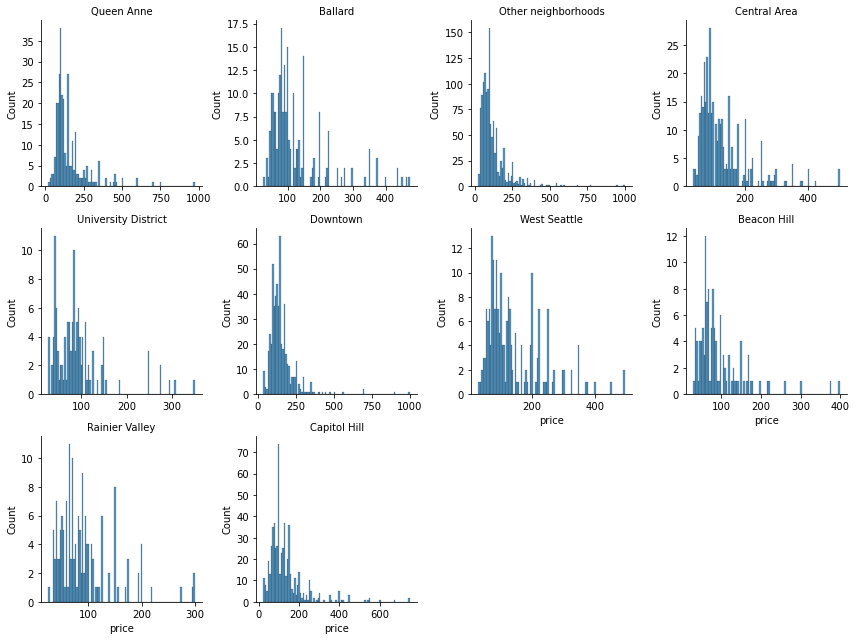

In [29]:
g = sb.FacetGrid(listings, col='neighbourhood_group_cleansed', col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(sb.histplot, x='price', bins=100)
g.set_titles(col_template="{col_name}")

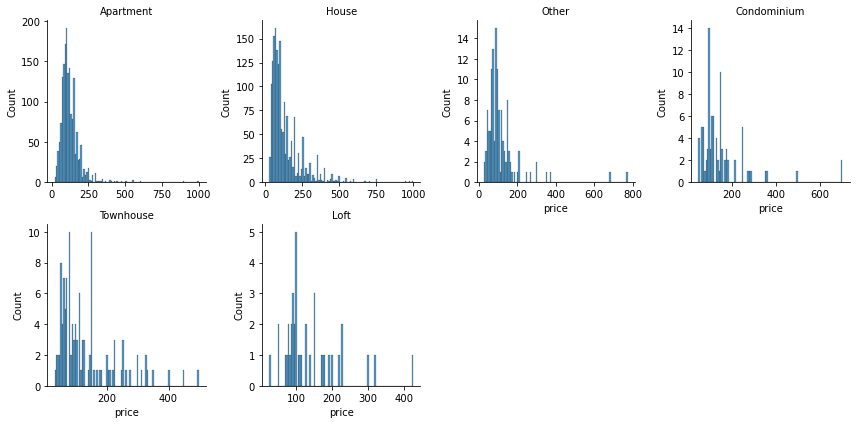

In [30]:
g = sb.FacetGrid(listings, col='property_type', col_wrap=4, sharex = False, sharey=False)
g.map_dataframe(sb.histplot, x='price', bins=100)
g.set_titles(col_template="{col_name}")

This facet grid of histograms of price by neighboorhood group and property type above tells us that while there may be differences in the mean price by each category, the number of data points for each category can be very disparate, which is also important to account for in answering the primary question because of how data volume can impact the spread. This can also be illustrated by juxtaposing bar plots and violin plots as shown below.

In [31]:
def bar_violin_plot(num_feature, cat_feature, x_label, y_label, title, length, width):
    plt.figure(figsize=[length,width])
    ax1 = plt.subplot(2,1,1)
    sb.set_style("whitegrid")
    sb.barplot(data=listings, x=num_feature, y=cat_feature, color=sb.color_palette()[0], ax=ax1,
           order=listings.groupby([cat_feature]).mean()[num_feature].sort_values(ascending=False).index, ci=None)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title(title)
    
    ax2 = plt.subplot(2,1,2)
    sb.violinplot(data=listings, x=num_feature, y=cat_feature, color=sb.color_palette()[0], ax=ax2,
           order=listings.groupby([cat_feature]).mean()[num_feature].sort_values(ascending=False).index, ci=None)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    
    

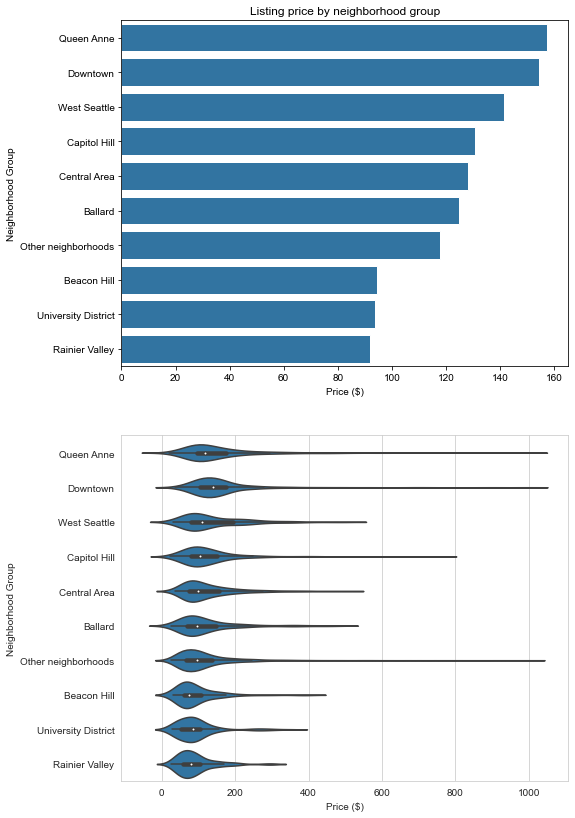

In [32]:
bar_violin_plot('price', 'neighbourhood_group_cleansed', 'Price ($)', 'Neighborhood Group', 
                'Listing price by neighborhood group', 8, 14)

In [33]:
listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    1225
Capitol Hill            567
Downtown                530
Central Area            369
Queen Anne              295
Ballard                 230
West Seattle            203
Rainier Valley          159
University District     122
Beacon Hill             118
Name: neighbourhood_group_cleansed, dtype: int64

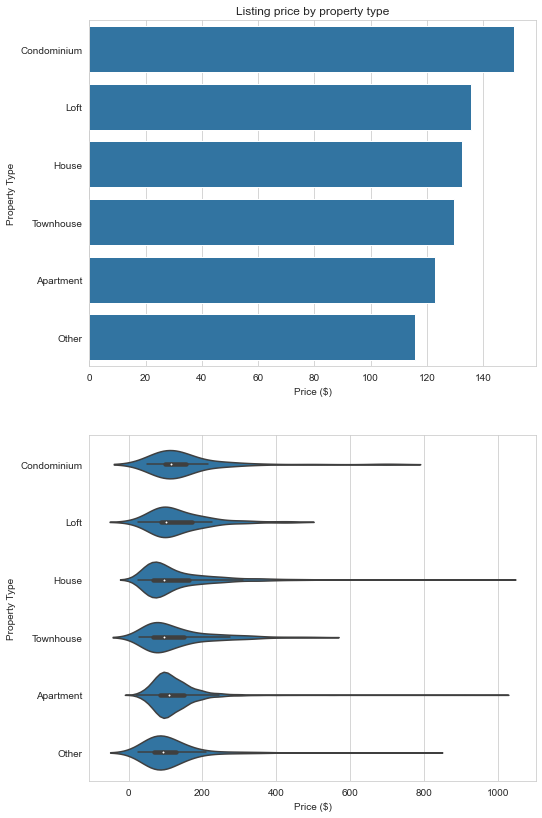

In [34]:
bar_violin_plot('price', 'property_type', 'Price ($)', 'Property Type',
                'Listing price by property type', 8, 14)

In [35]:
listings['property_type'].value_counts()

House          1733
Apartment      1708
Other           127
Townhouse       118
Condominium      91
Loft             40
Name: property_type, dtype: int64

The three most expensive neighborhood groups on average tended to be Queen Anne, Downtown and West Seattle. Of these three, Downtown had the most listings and in fact had the second most listings overall. The three cheapest neighborhood groups were Beacon Hill, University District and Rainier Valley, which also had the fewest listings among all neighborhood groups.

The most expensive property type on average was the condominium, but there were far fewer listings of those types. Houses were the third most expensive and had the most listings of all property types.

## Question 2: What features best correlate to high ratings for listings?

In [36]:
listings_num.drop(columns='id', inplace=True)

In [37]:
listings_num[[col for col in listings_num.columns if 'review_scores' in col]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review_scores_rating         3171 non-null   float64
 1   review_scores_accuracy       3160 non-null   float64
 2   review_scores_checkin        3160 non-null   float64
 3   review_scores_cleanliness    3165 non-null   float64
 4   review_scores_communication  3167 non-null   float64
 5   review_scores_location       3163 non-null   float64
 6   review_scores_value          3162 non-null   float64
dtypes: float64(7)
memory usage: 208.9 KB


In [38]:
review_scores = listings_num[[col for col in listings_num.columns if 'review_scores' in col]].dropna()
review_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3158 entries, 0 to 3814
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review_scores_rating         3158 non-null   float64
 1   review_scores_accuracy       3158 non-null   float64
 2   review_scores_checkin        3158 non-null   float64
 3   review_scores_cleanliness    3158 non-null   float64
 4   review_scores_communication  3158 non-null   float64
 5   review_scores_location       3158 non-null   float64
 6   review_scores_value          3158 non-null   float64
dtypes: float64(7)
memory usage: 197.4 KB


In [39]:
X = review_scores.drop(columns='review_scores_rating')
y = review_scores['review_scores_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
r2_score(y_test, y_pred)

0.6372625619317189

In [40]:
lm.coef_

array([1.4860041 , 1.54851985, 2.34098924, 1.2717486 , 0.55625523,
       2.90630231])

In [41]:
lm.feature_names_in_

array(['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value'], dtype=object)

In [42]:
review_score_coeffs = pd.DataFrame(data=lm.coef_, index=lm.feature_names_in_, columns=['coefficients'])
review_score_coeffs

,coefficients
review_scores_accuracy,1.486004
review_scores_checkin,1.548520
review_scores_cleanliness,2.340989
review_scores_communication,1.271749
review_scores_location,0.556255
review_scores_value,2.906302


Text(0.5, 0.98, 'Rating Score Against Specific Scores')

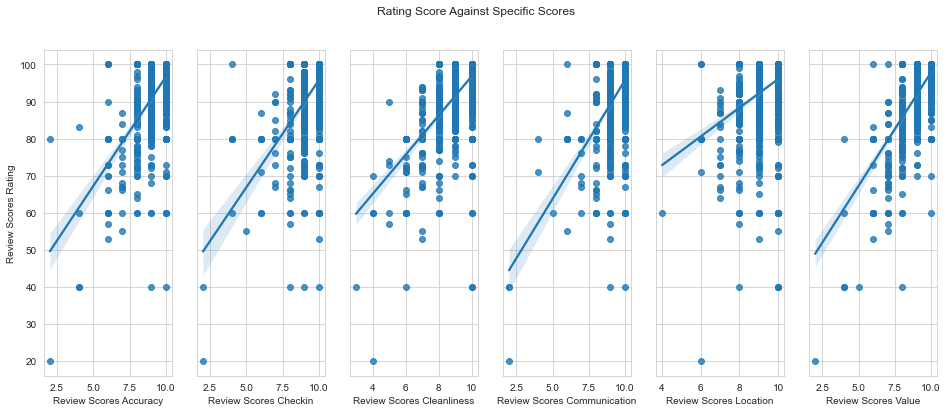

In [43]:
fig, ax = plt.subplots(1, 6, figsize=(16,6))

for i,col in enumerate(X.columns):
    sb.regplot(x=X[col], y=y, ax=ax[i])
    if i > 0:
        ax[i].set_ylabel('')
        ax[i].set_yticklabels('')
    else:
        ax[i].set_ylabel('Review Scores Rating')
    ax[i].set_xlabel(col.replace('_', ' ').title())

fig.suptitle('Rating Score Against Specific Scores')

<AxesSubplot:>

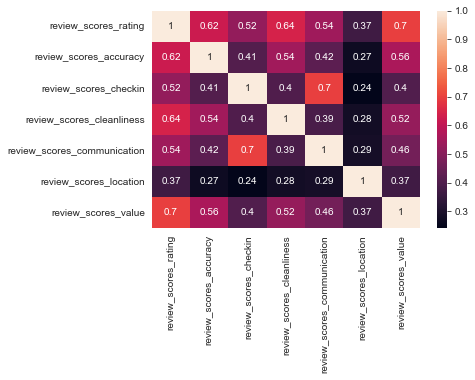

In [44]:
sb.heatmap(review_scores.corr(), annot=True)

First I wanted to see how the overall ratings correlated to more specific review scores. By fitting a linear regression model to those review scores as the independent variables and the overall rating as the dependent variable, we can see that overall ratings correlate positively to all of them as expected, but the relative strength of those correlations is shown by the heat map above, and it's clear that the strongest correlation is between the overall rating and review scores that assess the value of the listing, which shows that reviewers likely place more worth of a listing on its value.

In [45]:
listings_ratings = listings_num.dropna().drop(columns=['review_scores_accuracy', 'review_scores_checkin',
                                                       'review_scores_cleanliness', 'review_scores_communication',
                                                       'review_scores_location', 'review_scores_value'])

listings_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2655 entries, 0 to 3814
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   host_response_rate                                2655 non-null   float64
 1   host_acceptance_rate                              2655 non-null   float64
 2   host_is_superhost                                 2655 non-null   float64
 3   accommodates                                      2655 non-null   int64  
 4   bathrooms                                         2655 non-null   float64
 5   bedrooms                                          2655 non-null   float64
 6   price                                             2655 non-null   float64
 7   guests_included                                   2655 non-null   int64  
 8   extra_people                                      2655 non-null   float64
 9   number_of_reviews  

In [46]:
X = listings_ratings.drop(columns='review_scores_rating')
y = (listings_ratings['review_scores_rating'] - listings_ratings['review_scores_rating'].min()) / (listings_ratings['review_scores_rating'].max() - listings_ratings['review_scores_rating'].min())
# I normalize the ratings above so that they're not on a scale of 0-100 but this time on a 0-1 scale

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
r2_score(y_test, y_pred)

0.08086722748638364

In [47]:
all_coeffs = pd.DataFrame(data=lm.coef_, index=lm.feature_names_in_, columns=['coefficients'])
all_coeffs.sort_values(by='coefficients')

,coefficients
neighbourhood_group_cleansed_University District,-0.084014
property_type_Apartment,-0.015673
neighbourhood_group_cleansed_Downtown,-0.013703
property_type_Loft,-0.012950
property_type_House,-0.009436
neighbourhood_group_cleansed_Rainier Valley,-0.007120
host_response_time_within a few hours,-0.006363
property_type_Condominium,-0.006342
neighbourhood_group_cleansed_Capitol Hill,-0.006240
host_response_time_a few days or more,-0.006059


Next I fitted another linear regression model between the overall rating and all the other features that had nothing to do with review scores. With the caveat that the R-squared score is rather low because we're fitting a linear regression model with a lot of dummy variables, we can actually see that some categorical features have greater predictive value for overall ratings. For example, if a host is a superhost, they're much more likely to get higher ratings. On the other hand, listings in the University District get lower ratings than all other listings, as can be seen in the bar chart below. The violin plot also shows a greater spread for the review score of listings in the University District, which adds further affirmation to the notion that listings there are more likely to be rated poorly.

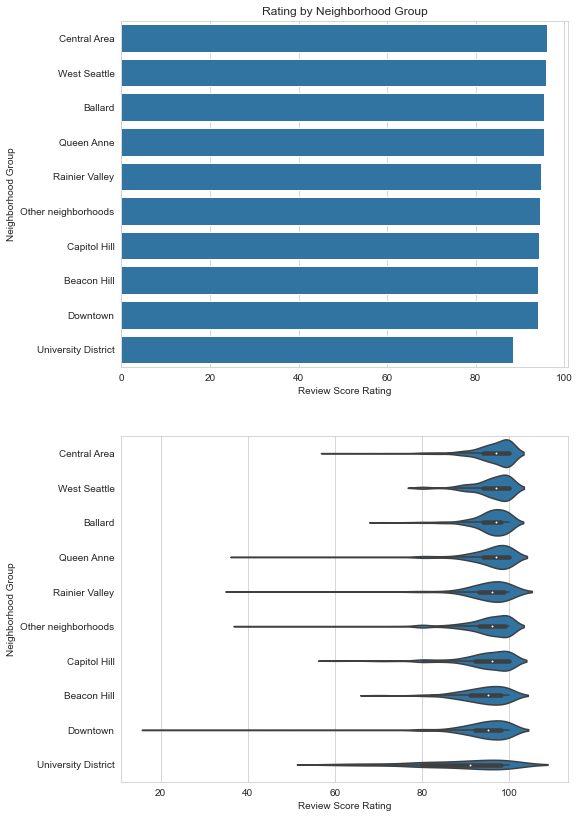

In [48]:
bar_violin_plot('review_scores_rating', 'neighbourhood_group_cleansed', 'Review Score Rating', 'Neighborhood Group',
                'Rating by Neighborhood Group', 8, 14)

In [49]:
listings.groupby(['neighbourhood_group_cleansed']).mean()['review_scores_rating'].sort_values()

neighbourhood_group_cleansed
University District    88.437500
Downtown               93.958333
Beacon Hill            94.019417
Capitol Hill           94.184783
Other neighborhoods    94.483034
Rainier Valley         94.731343
Queen Anne             95.443089
Ballard                95.533679
West Seattle           95.864198
Central Area           96.009404
Name: review_scores_rating, dtype: float64

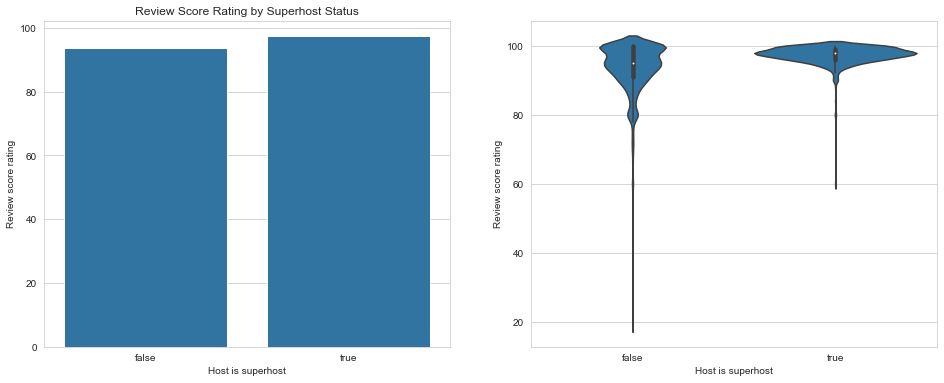

In [50]:
fig, ax = plt.subplots(1, 2, figsize=[16,6])

sb.barplot(data=listings, x='host_is_superhost', y='review_scores_rating', ax=ax[0], color=sb.color_palette()[0], ci=None)
ax[0].set_xticklabels(['false', 'true'])
ax[0].set_xlabel('Host is superhost')
ax[0].set_ylabel('Review score rating')
ax[0].set_title('Review Score Rating by Superhost Status')

sb.violinplot(data=listings, x='host_is_superhost', y='review_scores_rating', color=sb.color_palette()[0], ax=ax[1])
ax[1].set_xticklabels(['false', 'true'])
ax[1].set_xlabel('Host is superhost')
ax[1].set_ylabel('Review score rating');

In [51]:
listings.groupby(['host_is_superhost']).mean()['review_scores_rating'].sort_values()

host_is_superhost
f    93.652893
t    97.395473
Name: review_scores_rating, dtype: float64

## Question 3: What kinds of listings get high numbers of reviews?

In [52]:
listings_num_reviews = listings_num.dropna()[[col for col in listings_num.columns if 'review_scores' not in col]]
listings_num_reviews.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'accommodates', 'bathrooms', 'bedrooms', 'price', 'guests_included',
       'extra_people', 'number_of_reviews', 'num_amenities',
       'host_response_time_a few days or more',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour',
       'neighbourhood_group_cleansed_Ballard',
       'neighbourhood_group_cleansed_Beacon Hill',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Central Area',
       'neighbourhood_group_cleansed_Downtown',
       'neighbourhood_group_cleansed_Queen Anne',
       'neighbourhood_group_cleansed_Rainier Valley',
       'neighbourhood_group_cleansed_University District',
       'neighbourhood_group_cleansed_West Seattle', 'property_type_Apartment',
       'property_type_Condominium', 'property_type_House',
       'property_type_Loft', 'property_type_Townhouse'],

In [53]:
X = listings_num_reviews.drop(columns='number_of_reviews')
y = listings_num_reviews['number_of_reviews']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
r2_score(y_test, y_pred)

0.07013679426670238

In [54]:
all_coeffs = pd.DataFrame(data=lm.coef_, index=lm.feature_names_in_, columns=['coefficients'])
all_coeffs.sort_values(by='coefficients')

,coefficients
property_type_Condominium,-31.017802
property_type_Townhouse,-28.895386
property_type_Apartment,-17.060758
property_type_House,-14.465355
neighbourhood_group_cleansed_University District,-9.803429
host_response_time_a few days or more,-4.261904
host_response_time_within a day,-4.027389
bathrooms,-3.213133
neighbourhood_group_cleansed_West Seattle,-2.466787
num_amenities,-0.483886


Again, the R-squared score is low due to the high number of dummy variables for categorical features being fitted in this linear regression model, but we can see that listings that are lofts, which consist of the lowest number of listings of all the property types, are far more likely to get more reviews than other property types, and that superhosts get 20 more reviews on average than those who are not.

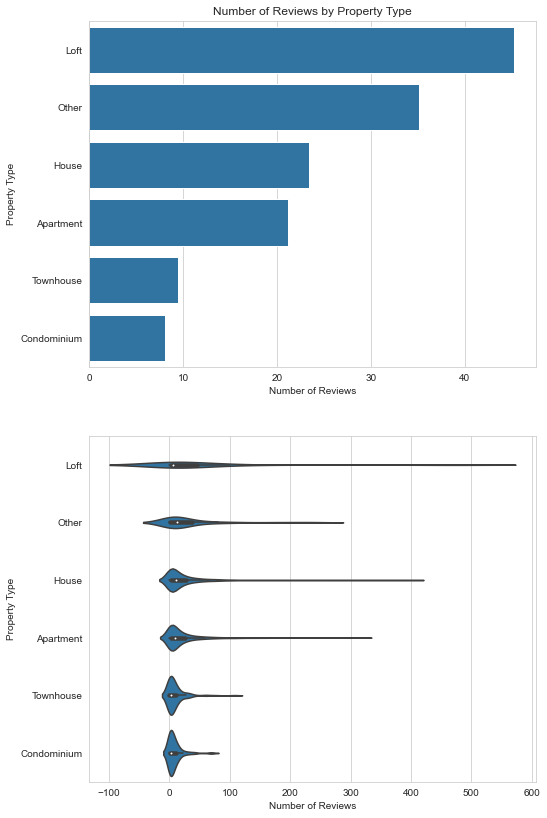

In [55]:
bar_violin_plot('number_of_reviews', 'property_type', 'Number of Reviews', 'Property Type',
                'Number of Reviews by Property Type', 8, 14)

In [56]:
listings.groupby(['property_type']).mean()['number_of_reviews'].sort_values()

property_type
Condominium     8.065934
Townhouse       9.483051
Apartment      21.213115
House          23.366994
Other          35.094488
Loft           45.300000
Name: number_of_reviews, dtype: float64

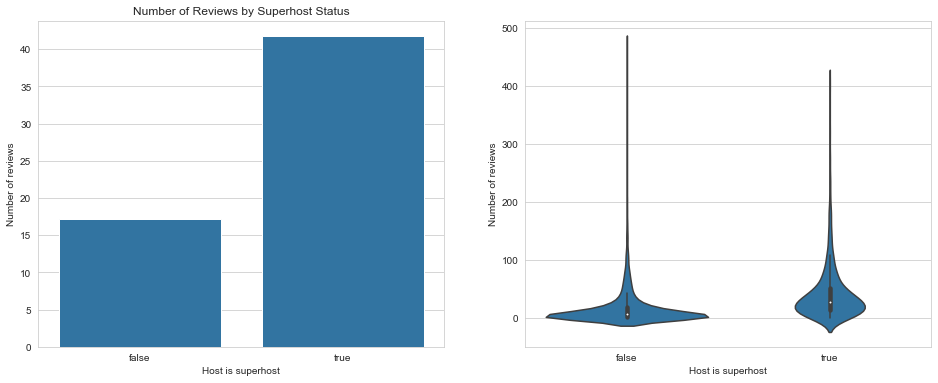

In [57]:
fig, ax = plt.subplots(1, 2, figsize=[16,6])

sb.barplot(data=listings, x='host_is_superhost', y='number_of_reviews', ax=ax[0], color=sb.color_palette()[0], ci=None)
ax[0].set_xticklabels(['false', 'true'])
ax[0].set_xlabel('Host is superhost')
ax[0].set_ylabel('Number of reviews')
ax[0].set_title('Number of Reviews by Superhost Status')

sb.violinplot(data=listings, x='host_is_superhost', y='number_of_reviews', color=sb.color_palette()[0], ax=ax[1])
ax[1].set_xticklabels(['false', 'true'])
ax[1].set_xlabel('Host is superhost')
ax[1].set_ylabel('Number of reviews');

In [58]:
listings.groupby(['host_is_superhost']).mean()['number_of_reviews'].sort_values()

host_is_superhost
f    17.235681
t    41.757069
Name: number_of_reviews, dtype: float64

In [59]:
listings['extra_people'].describe()

count    3818.000000
mean       10.667627
std        17.585922
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max       300.000000
Name: extra_people, dtype: float64

## Question 4: What months of the year are most common for bookings in multi-bedroom listings?

In [60]:
reviews = pd.read_csv('reviews.csv')

In [61]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [62]:
reviews['reviewer_id'].value_counts()

206203      67
15121499    32
2734499     19
5775807     19
29590276    18
            ..
24843087     1
24662663     1
5266145      1
28944689     1
30860360     1
Name: reviewer_id, Length: 75730, dtype: int64

In [63]:
reviews['date'] = pd.to_datetime(reviews['date'])
reviews['date']

0       2015-07-19
1       2015-07-20
2       2015-07-26
3       2015-08-02
4       2015-08-10
           ...    
84844   2015-10-12
84845   2015-10-17
84846   2015-10-20
84847   2015-11-02
84848   2015-12-13
Name: date, Length: 84849, dtype: datetime64[ns]

In [64]:
reviews['date'].describe(datetime_is_numeric=True)

count                            84849
mean     2014-12-26 21:05:14.775660288
min                2009-06-07 00:00:00
25%                2014-08-09 00:00:00
50%                2015-05-16 00:00:00
75%                2015-08-27 00:00:00
max                2016-01-03 00:00:00
Name: date, dtype: object

In [65]:
reviews['month'] = reviews['date'].dt.month
reviews['week'] = reviews['date'].dt.isocalendar().week

In [66]:
reviews[['listing_id', 'week']]

,listing_id,week
0,7202016,29
1,7202016,30
2,7202016,30
3,7202016,31
4,7202016,33
...,...,...
84844,3624990,42
84845,3624990,42
84846,3624990,43
84847,3624990,45


In [67]:
reviews = reviews.merge(listings, left_on='listing_id', right_on='id')
reviews

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,month,week,id_y,host_response_time,...,extra_people,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,num_amenities
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,7,29,7202016,within an hour,...,0.0,16,95.0,10.0,10.0,10.0,10.0,10.0,10.0,12
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,7,30,7202016,within an hour,...,0.0,16,95.0,10.0,10.0,10.0,10.0,10.0,10.0,12
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",7,30,7202016,within an hour,...,0.0,16,95.0,10.0,10.0,10.0,10.0,10.0,10.0,12
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,8,31,7202016,within an hour,...,0.0,16,95.0,10.0,10.0,10.0,10.0,10.0,10.0,12
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,8,33,7202016,within an hour,...,0.0,16,95.0,10.0,10.0,10.0,10.0,10.0,10.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...,10,42,3624990,within an hour,...,0.0,18,90.0,10.0,10.0,9.0,10.0,9.0,9.0,13
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...,10,42,3624990,within an hour,...,0.0,18,90.0,10.0,10.0,9.0,10.0,9.0,9.0,13
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del...",10,43,3624990,within an hour,...,0.0,18,90.0,10.0,10.0,9.0,10.0,9.0,9.0,13
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si...",11,45,3624990,within an hour,...,0.0,18,90.0,10.0,10.0,9.0,10.0,9.0,9.0,13


In [68]:
date_bedrooms = reviews[['month', 'week', 'bedrooms']].dropna()
date_bedrooms['bedrooms'] = date_bedrooms['bedrooms'].astype('int')
date_bedrooms.head()

,month,week,bedrooms
0,7,29,1
1,7,30,1
2,7,30,1
3,8,31,1
4,8,33,1


Text(0.5, 1.0, 'Number of Bookings by Month and Number of Bedrooms')

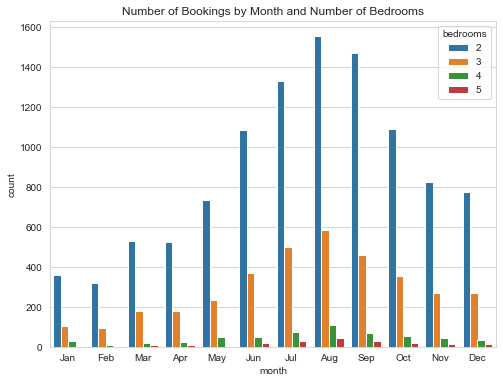

In [69]:
plt.figure(figsize = [8,6])
g = sb.countplot(data=date_bedrooms.query('(bedrooms > 1) & (bedrooms < 6)'), x='month', hue='bedrooms');
g.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);
plt.title('Number of Bookings by Month and Number of Bedrooms')

For 2-5 bedroom listings, the months of August and September are the most commonly booked based on the number of reviews written., while January and February are the least commonly booked. This indicates that the summer months are the most popular times of travel to Seattle for families and larger groups.